## BDAD Project  - Team D

#### Sentiment Classification

In [1]:
# # |
# # Install pyspark
# ! pip install pyspark==2.4.4

# # Install Spark NLP
# ! pip install --ignore-installed spark-nlp

In [1]:
## import dependencies
import findspark
findspark.init()

import pyspark
pyspark.version

<module 'pyspark.version' from 'C:\\spark\\spark-2.4.5-bin-hadoop2.7\\python\\pyspark\\version.py'>

In [2]:
# !pip install findspark 

In [3]:
import sparknlp

spark = sparknlp.start(gpu=True)

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version", spark.version)


Spark NLP version:  2.5.5
Apache Spark version 2.4.5


downloading IMDB movie reviews dataset for training our multi-class sentiment classifier

In [4]:
!wget -O aclimdb_train.csv https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/aclimdb/aclimdb_train.csv

--2020-08-25 15:34:41--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/aclimdb/aclimdb_train.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.88.101
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.88.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33497180 (32M) [text/csv]
Saving to: 'aclimdb_train.csv'

     0K .......... .......... .......... .......... ..........  0%  111K 4m56s
    50K .......... .......... .......... .......... ..........  0% 1.10M 2m42s
   100K .......... .......... .......... .......... ..........  0%  205K 2m41s
   150K .......... .......... .......... .......... ..........  0% 10.7M 2m1s
   200K .......... .......... .......... .......... ..........  0%  210K 2m8s
   250K .......... .......... .......... .......... ..........  0% 7.98M 1m47s
   300K .......... .......... .......... .......... ..........  1% 6.12M 92s
   350K .......... .......... .......... .......... ..

In [5]:
!wget -O aclimdb_test.csv https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/aclimdb/aclimdb_test.csv

--2020-08-25 15:34:49--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/aclimdb/aclimdb_test.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.18.115
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.18.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32715164 (31M) [text/csv]
Saving to: 'aclimdb_test.csv'

     0K .......... .......... .......... .......... ..........  0%  102K 5m14s
    50K .......... .......... .......... .......... ..........  0% 9.53M 2m38s
   100K .......... .......... .......... .......... ..........  0%  205K 2m37s
   150K .......... .......... .......... .......... ..........  0% 10.7M 1m58s
   200K .......... .......... .......... .......... ..........  0%  209K 2m5s
   250K .......... .......... .......... .......... ..........  0% 9.64M 1m44s
   300K .......... .......... .......... .......... ..........  1% 11.2M 90s
   350K .......... .......... .......... .......... ...

In [6]:
# !head -n 5 aclimdb_train.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


The content is inside `text` column and the sentiment is inside `label` column

In [5]:
trainDataset = spark.read \
              .option("header",True)\
              .csv("aclimdb_train.csv")

In [6]:
trainDataset.show()

+--------------------+--------+
|                text|   label|
+--------------------+--------+
|This is an Excell...|positive|
|The Sarah Silverm...|positive|
|"Prom Night" is a...|negative|
|So often a band w...|positive|
|"Pet Sematary" is...|positive|
|I watched the fil...|negative|
|Boy this movie ha...|negative|
|Checking the spoi...|negative|
|Despite its rathe...|positive|
|Absolute masterpi...|positive|
|The tweedy profes...|positive|
|A movie best summ...|negative|
|Take young, prett...|negative|
|For months I've b...|negative|
|"Batman: The Myst...|positive|
|Well, it was funn...|negative|
|I have seen the s...|positive|
|Brainless film ab...|negative|
|Leave it to geniu...|negative|
|Seven Pounds star...|positive|
+--------------------+--------+
only showing top 20 rows



In [7]:
type(trainDataset)

pyspark.sql.dataframe.DataFrame

In [8]:
trainDataset.count()

25000

In [9]:
# importing dependencies for creating pipeline
from pyspark.ml import Pipeline

from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

In [10]:
# actual content is inside description column

## setting up the trainin pipeline

document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

## sentence encoder 
use = UniversalSentenceEncoder.pretrained() \
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
sentimentdl = SentimentDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("label")\
  .setMaxEpochs(5)\
  .setEnableOutputLogs(True)


## build the pipeline
pipeline = Pipeline(
    stages = [
        document,
        use,
        sentimentdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [11]:
pipelineModel = pipeline.fit(trainDataset)   ## fit pipeline

In [12]:
# !cd ~/annotator_logs && ls -l

In [13]:
# !cat ~/annotator_logs/SentimentDLApproach_2ea7dc3149c2.log

#### (optional) use only when you want to save your pipeline



In [14]:
load_df = spark.createDataFrame([
    "This movie is a delight for those of all ages. I have seen it several times and each time I am enchanted by the characters and magic. The cast is outstanding, the special effects delightful, everything most believable.",
    "This film was to put it simply rubbish. The child actors couldn't act, as can be seen by Harry's supposed surprise on learning he's a wizard. I'm a wizard! is said with such indifference you'd think he's not surprised at all."
], StringType()).toDF("text")

NameError: name 'StringType' is not defined

## Save and load trained pipeline

In [ ]:
## if you're running in colab , it is not recommended to run this cell as colab has memory limitations
## run if your running locally

# pipelineModel.save("./sentimentdl_pipeline")
# loadedPipeline = PipelineModel.load("./sentimentdl_pipeline")
# loadedPipeline.transform(load_df)

## Save and load pre-trained SentimentDL model

In [ ]:
# hdfs:/ if you are saving it on distributed file systems in Hadoop
pipelineModel.stages[-1].write().overwrite().save('./tmp_sentimentdl_model')



Let's use our pre-trained SentimentDLModel in a pipeline: 

In [ ]:
# In a new pipeline you can load it for prediction
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained() \
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

sentimentdl = SentimentDLModel.load("./tmp_sentimentdl_model") \
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")

pipeline = Pipeline(
    stages = [
        document,
        use,
        sentimentdl
    ])


Now let's load it back so we can have prediction all together with everything in that pipeline:

In [ ]:
from pyspark.sql.types import StringType

dfTest = spark.createDataFrame([
    "This movie is a delight for those of all ages. I have seen it several times and each time I am enchanted by the characters and magic. The cast is outstanding, the special effects delightful, everything most believable.",
    "This film was to put it simply rubbish. The child actors couldn't act, as can be seen by Harry's supposed surprise on learning he's a wizard. I'm a wizard! is said with such indifference you'd think he's not surprised at all."
], StringType()).toDF("text")

In [ ]:
type(dfTest)

In [ ]:
prediction = pipeline.fit(dfTest).transform(dfTest)

In [ ]:
prediction.select("class.result").show()

prediction.select("class.metadata").show(truncate=False)

# Evaluation 

Let's evaluate our SentimentDL model we trained earlier, saved it, and loaded it into a new pipeline by using a test dataset that model has never seen:

In [ ]:
testDataset = spark.read \
      .option("header", True) \
      .csv("aclimdb_test.csv")

In [ ]:
type(testDataset)

In [ ]:
preds = pipelineModel.transform(testDataset)

In [ ]:
preds.select('label','text',"class.result").show(50, truncate=50)

In [ ]:
preds_df = preds.select('label','text',"class.result").toPandas()

In [ ]:
preds_df['result'].value_counts()

In [ ]:
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

The `SentimentDL` has the ability to accept a threshold to set a label on any result that is less than that number. 

For instance, by default the threshold is set on `0.6` and everything below that will be assigned as `neutral`. You can change this label with `setThresholdLabel`.

We need to filter `neutral` results since we don't have any in the original test dataset to compare with.

In [68]:
preds_df['result'].value_counts()

n    13224
p    11235
Name: result, dtype: int64

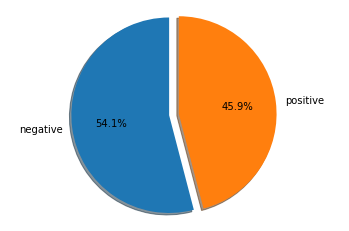

In [70]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
labels = ['negative','positive']
ax.pie(preds_df["result"].value_counts(),explode=(0,0.1),labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')

plt.show()

c:\users\dhruv\anaconda3\envs\nlp\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


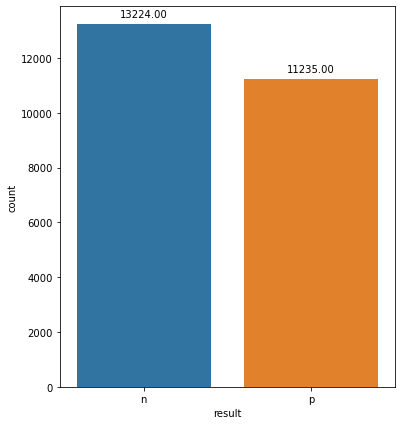

In [82]:
plt.figure(figsize=(6,7))
plot_df = preds_df['result'].apply(lambda x : x[0])
import seaborn as sns
splot = sns.countplot(plot_df)

for p in splot.patches:
		splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [45]:
preds_df = preds_df[preds_df['result'] != 'neutral']


In [46]:
# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report , plot_confusion_matrix

Let's use `classification_report` from `sklearn` to evaluate the final scores. (keep in mind due to limited resources on a free Google Colab we only used 5 Epochs :)

In [47]:
print (classification_report(preds_df['result'], preds_df['label']))

              precision    recall  f1-score   support

    negative       0.90      0.83      0.86     13224
    positive       0.82      0.89      0.85     11235

    accuracy                           0.86     24459
   macro avg       0.86      0.86      0.86     24459
weighted avg       0.86      0.86      0.86     24459



In [40]:
preds_df.tail()

,label,text,result
24995,positive,This show has an amazing plot with good and re...,negative
24996,positive,I don't know what Dick steel was talking about...,negative
24997,positive,Aaliyah blows all the female cast members out ...,positive
24998,negative,the movie is complete disaster. i don't know w...,negative
24999,negative,"First, I am a big fan of Alien and Alien II - ...",negative


In [65]:
def test_sentiment_func():
    test_input=input()
    test_sentence_df = spark.createDataFrame([test_input],StringType()).toDF("text")
    test_pred = pipeline.fit(test_sentence_df).transform(test_sentence_df)
    test_ans_df=test_pred.select("class.result").toPandas()
    print(test_ans_df)

    

In [62]:
# test_sentence_df = spark.createDataFrame([
#     "This movie is a delight for those of all ages. I have seen it several times and each time I am enchanted by the characters and magic. The cast is outstanding, the special effects delightful, everything most believable.",
#     "This film was to put it simply rubbish. The child actors couldn't act, as can be seen by Harry's supposed surprise on learning he's a wizard. I'm a wizard! is said with such indifference you'd think he's not surprised at all."
# ], StringType()).toDF("text")

In [67]:
test_sentiment_func()

today is a great day to work
       result
0  [positive]
